# Project 1: Write a Data Science Blog Post

This project is part of the UDACITY program for data scientists. We are asked to take any dataset online, answer business questions, and present the result in a blog. The project subscribes to the CRISP-DM process <br><br>
In the present notebook, we analyze [the airbnb Berlin database from kaggle](https://www.kaggle.com/brittabettendorf/berlin-airbnb-data). The goal is to get insights for anyone willing to step in the airbnb market in Berlin. The outcomes will be presented in on the blog <br><br>
we want to answer the following business questions:
1. What neighbourhoods do guests prefer? 
2. What justifies the price?
3. How professional hosts stand out? 
4. Which language to communicate with guests? 


## Load libraries

In [1]:
import numpy as np        # linear algebra
import pandas as pd       # data processing, CSV file I/O
import matplotlib.pyplot as plt    # basic viisualization
import seaborn as sns     # advanced viisualization
import geopandas as gpd   # pandas extension for map representation 
import geoplot as gplt    # map visualization
import geoplot.crs as gcrs # coordinate reference system
import sys
import os

# parse file system
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.options.display.float_format = '{:.2f}'.format

data\balance_pro.png
data\berlin-wall.geojson
data\calendar_summary.csv
data\correlation_matrix.png
data\desnity_listings_per_region.png
data\feature_relevance.png
data\language_distribution.png
data\language_precentage.png
data\LICENSE
data\listings.csv
data\listings_summary.csv
data\logo.png
data\neighbourhoods.csv
data\neighbourhoods.geojson
data\pro_distribution.png
data\README.md
data\reviews.csv
data\reviews_summary.csv
data\reviews_summary_with_language.csv
data\reviews_summary_with_language3.csv
data\review_scores_per_regions.png
data\room_type_distribution_pro.png


## Data Overview

The dataset gather airbnb informations contains many csv files but we decide to **work with summary data frames only**. 
 - listings: contains many information for each accomodations/listings.
 - calendar: booking, availability, pricing over the course of a year (2018/2019) for each listing.
 - reviews: reviews over a decade (2009/2018) for each listing. 

In [2]:
#upload dataframes from files
reviews_df = pd.read_csv(r'data\reviews_summary.csv')
calendar_df = pd.read_csv(r'data\calendar_summary.csv')
listings_df = pd.read_csv(r'data\listings_summary.csv')

the barplots below illustrate the content of our data. The size of the bars depict how much data is present in each column. The rest are missing values. <span style='color:Blue'> Blue bars </span> represent columns with categorical data while <span style='color:Red'> red bars </span> represent columns with numerical data.

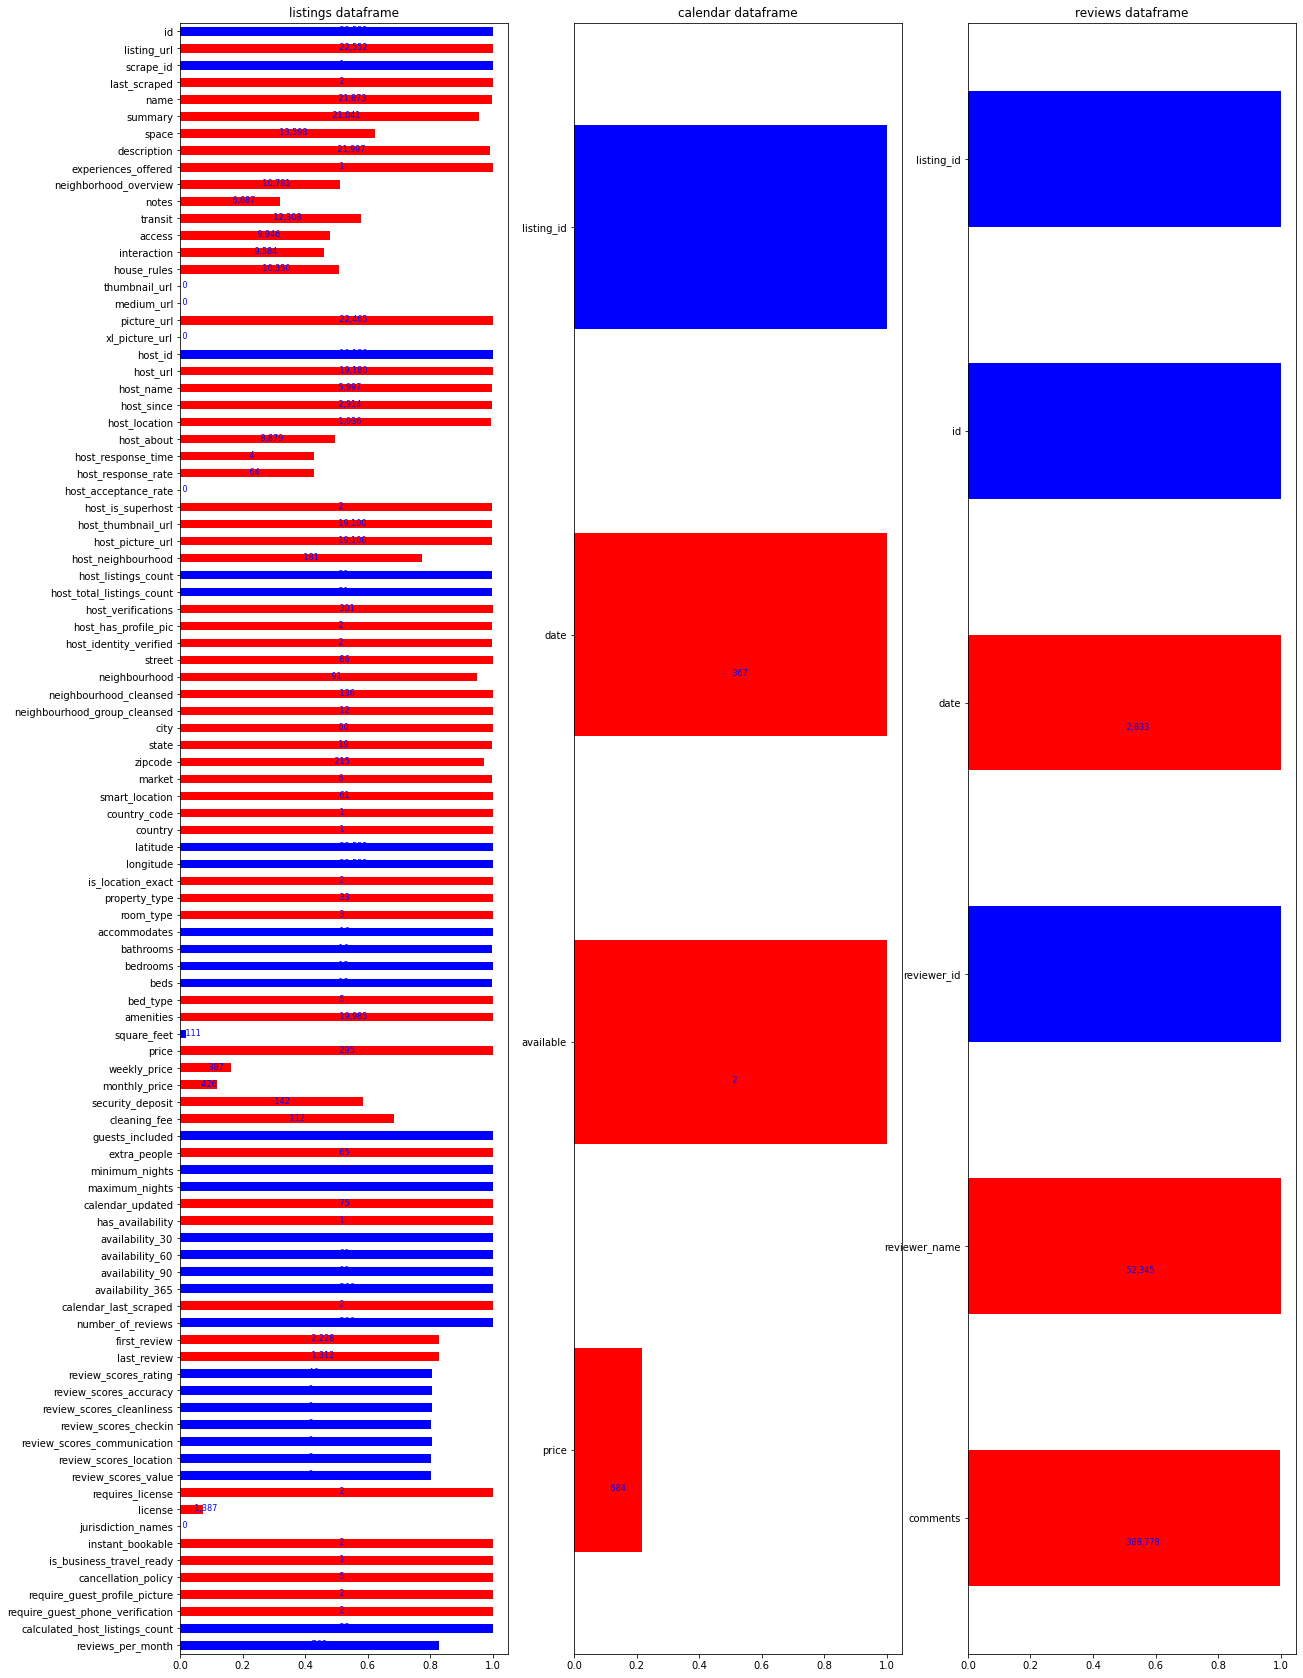

In [3]:
# function for annotating bars in data frame
def annotate(ax, values):
    """annotate bars in plot with values"""
    
    # for each bars in the plot,  write cardinality in the center of the bar
    for i  in range(len(ax.patches)):
        rect = ax.patches[i]
        ax.text(rect.get_width()/2, rect.get_y()+rect.get_height()/2+0.1," {:,}".format(values[i]), fontsize=8,color='blue')
    ax.invert_yaxis()


# place data frames in iterative object for plot purposes   
list_df = [listings_df, calendar_df, reviews_df]
titles = ['listings dataframe', 'calendar dataframe', 'reviews dataframe']

# create 3 horizontal barplots stacked in columns
fig, ax = plt.subplots(1, len(list_df), figsize=(20, 30))

# for each data frames in iterator, plot:
for i in range(len(list_df)):
    
    # set color of each bar: blue for numerical columns  and red for categorical columns
    color = list(map(lambda x: 'r' if x else 'b', (list_df[i].dtypes=='object').tolist()));
    
    # plot horizontal barplots
    list_df[i].notna().mean().plot(kind = 'barh', color=color, title=titles[i], ax=ax[i]);
    
    # annotate bars woth the cardinality of the corresponding column
    annotate(ax[i], list_df[i].nunique().tolist())

**Observations:** It is apparent that these data come from a relational database because of identifiable primary and foreign keys. It can be useful for joining operations. The listing dataframe is much more furnished than the other 2. There are much longer though.<br> 

We can already perceive ways for cleaning up data.

Remove columns:
- with too many missing values (ex: square_feet, host_acceptance_rate), 
- filled with single value (ex: country), 
- irrelevant to our study (ex: name, url)<br> 

Transform columns:
- with binary data stored as strings (ex:instant_bookable, is_location_exact)
- with numerical or date data stored as strings (ex: price, date)<br> 

# 1. What neighbourhoods do guests prefer? 

To answer this question, we decide to work with geospatial data. Listings come with longitude and latitude. In order to use this information, we need to get a map of Berlin from another [ airbnb database on kaggle](https://www.kaggle.com/raghavs1003/airbnb-berlin-2020).<br> 


### Geospatial grouping

1. We load the map. It is stored in an augmented dataframe enabled by geopandas library useful for geometrical and visual operations. Each row represents a region of Berlin and its boundaries in a polygon shape.

In [4]:
# upload neighbourhood shape dataframe from files
neigh_shape_df = gpd.read_file(r'data\neighbourhoods.geojson')
neigh_shape_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


2. For each region, we count the number of listings and calculate the relative mean score location. The listings (id) count per region shows the spread of airbnb accommodations. The mean score should reveal what regions guests prefered. Once attached to the region s shape, we have all ingredients for visualizing our 2 metrics on a map.


In [5]:
# first of all lets work with neighbourhood_cleansed columns as neighbourhood from now on
listings_df.drop('neighbourhood', axis=1, inplace = True)
listings_df.rename(columns={'neighbourhood_cleansed':'neighbourhood'}, inplace=True)

# aggregate listings with repsect to neighbourhood_cleansed for later merge with shapeDf
neigh_metrics_df = listings_df.groupby('neighbourhood')[['id', 'review_scores_location']]. \
                                agg({'id': 'count', 'review_scores_location': 'mean'})

# remname columns for consistency, id_count is the count of listings per neighbourhood 
# and mean_review_scores_location is the mean review score per neighbourhood
neigh_metrics_df.rename(columns={'id':'id_count', 'review_scores_location':'mean_review_scores_location'}, inplace=True)

# merge metrics with shapes on neighbourhoods
neigh_metrics_df = neigh_shape_df.merge(neigh_metrics_df, how='left', on='neighbourhood')

# remove mssing rows, essential for visualization
neigh_metrics_df.dropna(inplace=True)

### Visualization

1. Let's have a look to the distribution of listings in each neighbourhoods

C:\Users\guerrer\AppData\Local\Continuum\anaconda3\envs\geopandas_testenv\lib\site-packages\cartopy\mpl\geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


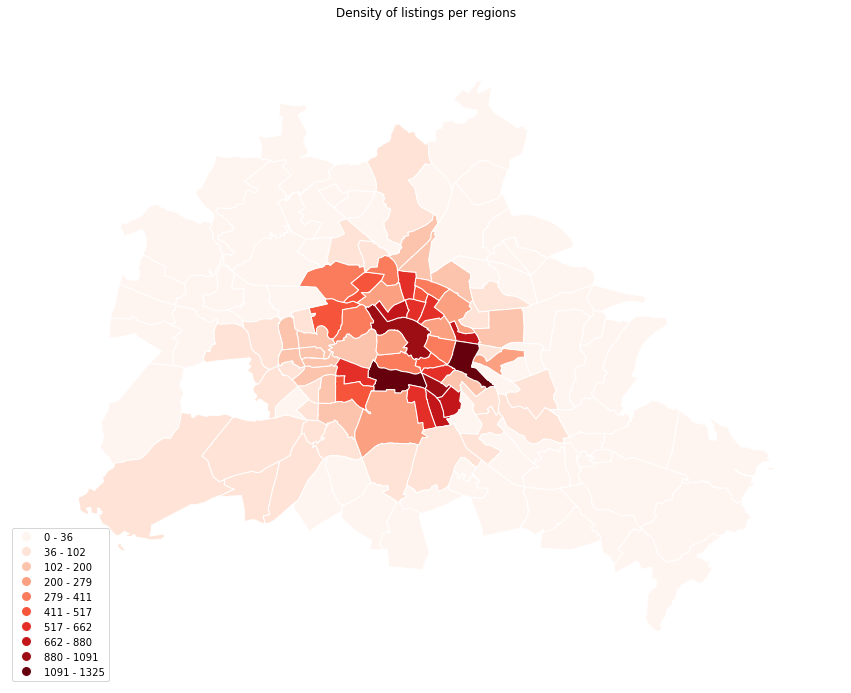

In [6]:
import mapclassify as mc

# set number of categories
NB_CAT = 10

# cluster ids count thanks to Jenks Natural Breaks algorithm
scheme_count = mc.FisherJenks(neigh_metrics_df['id_count'], k=NB_CAT)

# choropleth mapping of listing counts to neighbourhoods
ax = gplt.choropleth(neigh_metrics_df, hue='id_count', projection=gcrs.AlbersEqualArea(), edgecolor='white', linewidth=1, 
                cmap='Reds', legend=True, legend_kwargs={'loc':'lower left'}, scheme=scheme_count, figsize=(15, 15))

ax.set_title("Density of listings per regions");

2. Similarly, let's have a look at the distribution of the review score locations for each neighbourhood. 

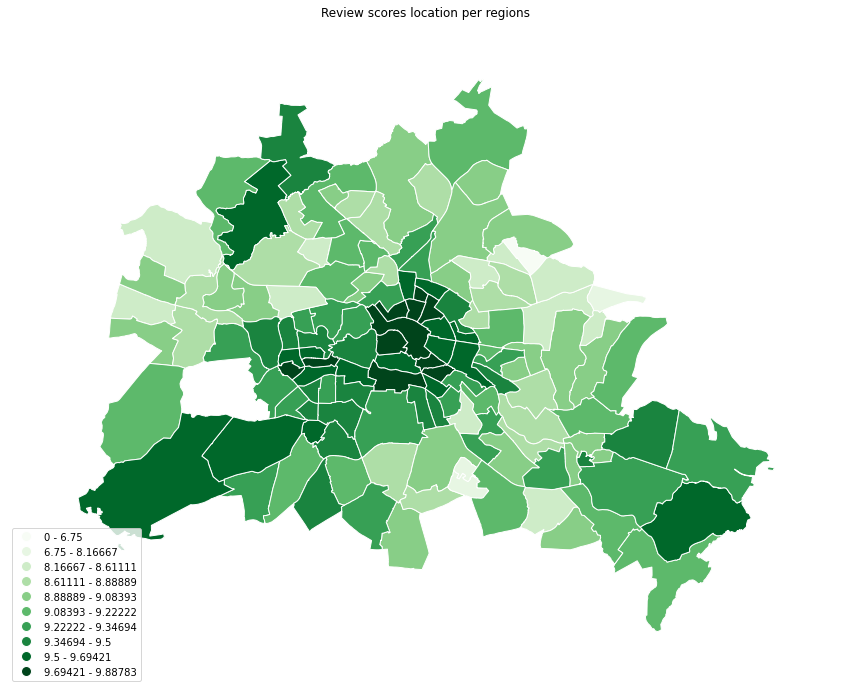

In [7]:
# set number of categories
NB_CAT = 10

# cluster counts thanks to Jenks Natural Breaks algorithm
scheme_mean = mc.FisherJenks(neigh_metrics_df['mean_review_scores_location'], k=NB_CAT)

# choropleth mapping of listing counts to neighbourhoods
ax = gplt.choropleth(neigh_metrics_df, hue='mean_review_scores_location', projection=gcrs.AlbersEqualArea(), \
                edgecolor='white', linewidth=1, cmap='Greens', legend=True, legend_kwargs={'loc': 'lower left'}, \
                scheme=scheme_mean, figsize=(15, 15))

ax.set_title("Review scores location per regions");

**Observations:**  From these 2 plots, we can compare how listings are distributed across the city against guests preferred places. The listings meet guests preference in the city center, within the Berlin ring (public transports). The offer is high and the guests like it. No surprise. The same trend is observable as we move slightly to the south west although the review score remains stable and the number of listings goes slowly down. Some Northern and South East neighbourhoods, outside the city center, show respectable review scores but the offer is quite low. These outer neighbourhoods have in common the proximity to lakes.

# 2. What justifies the price?

In  order to see what features justify the price, we will work with the listings dataframe only. The idea is to build a machine learning model that predicts the price. While training, the model should understand the underlying correlations between data and how they impact the price. Later,  we will play with the model to identify what features are the most relevant to him.

First, we have to clean up  the data frame and keep as much data as possible.

### data clean up

1.  We recover data that should be numeric but aren't.

In [8]:
clean_listings_df = pd.read_csv(r'data\listings_summary.csv')

# binarize remaining columns
binary_columns = clean_listings_df.columns[clean_listings_df.nunique() == 2].tolist()
clean_listings_df[binary_columns] = (clean_listings_df[binary_columns] == 't').astype(float)

# columns to transform
col_to_transform = ['extra_people', 'price', 'security_deposit', 'security_deposit', 'cleaning_fee', 'host_response_rate']

# transform columns having string types instead of numrical types
clean_listings_df[col_to_transform] = clean_listings_df[col_to_transform]. \
                    apply(lambda col : col.str.replace(r',|\$|%','').astype('float'), axis=0)

#impute nissing values
clean_listings_df[col_to_transform] = clean_listings_df[col_to_transform].fillna(0);

<ipython-input-8-7eeb71ab7899>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  apply(lambda col : col.str.replace(r',|\$|%','').astype('float'), axis=0)


2. We label encode categorical columns we consider important for price prediction.

In [9]:
# name the columns to encode, high cardinality (>2) but important to keep
col_to_encode = ['host_response_time', 'room_type', 'bed_type', 'cancellation_policy', 'property_type']

# encode important columns with cardinality higher than 2
clean_listings_df[col_to_encode] = clean_listings_df[col_to_encode].astype('category')
clean_listings_df[col_to_encode] = clean_listings_df[col_to_encode].apply(lambda col : col.cat.codes, axis=0)

3. Automatic clean up. We remove columns with high cardinality (>5) and too many missing values (>75%). The thresholds are chosen carefully for removing irrelevant columns as much as possible. dataframes IDs and scrape info pass through but we remove them right after. 

In [10]:
# function returning the name of columns not in respect with psecifications
def auto_cleanup(df, ratio, card):
    """ return list of columns name to be drop based on missing value ratio and maximum caridanlity tolerated """
    dropCondition = (((df.nunique()<=1) | (df.nunique()>card)) & (df.dtypes=='object')) | (df.notna().mean()<ratio)
    return df.columns[dropCondition].tolist()
    
# set parameter for auto clean up: 
MIN_PERCENT_THRESH = 0.25   # drop columns filled with less than 25% values 
CARDINAL_THRESH = 5         # drop columns with no variability or cardinality equal to one

# automatic cleanup
clean_listings_df = clean_listings_df.drop(auto_cleanup(clean_listings_df, MIN_PERCENT_THRESH, CARDINAL_THRESH), axis=1)

# columns to transform
col_to_remove = ['scrape_id', 'host_id', 'id', 'last_scraped', 'calendar_last_scraped']

# remove given columns
clean_listings_df.drop(col_to_remove, axis=1, inplace=True)

4. We impute missing data. At this stage. only the review scores are not complete. We fill up missing values with the mean. We assume that guests did not let any review because they were just satisfied with the service so we can consider the mean as a valid ersatz. The rest of data can be filled with column mode (most frequent value).

In [11]:
# identify review columns
col_reviews = clean_listings_df.columns[clean_listings_df.columns.str.contains('review')].tolist()

# impute review collumns with min values
clean_listings_df[col_reviews] = clean_listings_df[col_reviews].apply(lambda col: col.fillna(col.mean()), axis=0)

5. To be on the safe side, the rest of data can be filled with column mode (most frequent value).
Any rows with missing values are removed if persisting.

In [12]:
# impute missing values with modes
clean_listings_df = clean_listings_df.apply(lambda col: col.fillna(col.mode()[0]), axis=0)

# we amake sure there are no missing values at all
clean_listings_df.dropna(how='any', axis=0, inplace=True)

6. finally we can work with a data frame filled with numerical values only.

In [13]:
# print the ratio of lost data
print("original listing dataframe has %d rows and %d columns" % listings_df.shape)
print("clean listing dataframe has %d rows and %d columns" % clean_listings_df.shape)
print("We lost %.2f%% of data from original" % (100*(1-clean_listings_df.shape[0]/listings_df.shape[0])))
clean_listings_df.describe()

original listing dataframe has 22552 rows and 95 columns
clean listing dataframe has 22552 rows and 43 columns
We lost 0.00% of data from original


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,...,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00,22552.00
mean,0.38,39.35,0.13,2.33,2.33,1.00,0.39,52.51,13.41,0.74,...,9.73,9.51,9.41,1.00,0.31,0.88,0.01,0.01,1.92,1.14
std,1.71,47.21,0.34,19.94,19.94,0.06,0.49,0.03,0.06,0.44,...,0.62,0.68,0.75,0.02,0.46,0.83,0.08,0.11,3.67,1.37
min,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,52.35,13.10,0.00,...,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,0.01
25%,-1.00,0.00,0.00,1.00,1.00,1.00,0.00,52.49,13.38,0.00,...,9.73,9.00,9.00,1.00,0.00,0.00,0.00,0.00,1.00,0.22
50%,-1.00,0.00,0.00,1.00,1.00,1.00,0.00,52.51,13.42,1.00,...,10.00,9.51,9.41,1.00,0.00,1.00,0.00,0.00,1.00,0.84
75%,2.00,100.00,0.00,2.00,2.00,1.00,1.00,52.53,13.44,1.00,...,10.00,10.00,10.00,1.00,1.00,2.00,0.00,0.00,1.00,1.18
max,3.00,100.00,1.00,1676.00,1676.00,1.00,1.00,52.65,13.76,1.00,...,10.00,10.00,10.00,1.00,1.00,4.00,1.00,1.00,45.00,36.67


### Train model

From the newly-formed dataframe, we want to predict the price based on other features. It is a regression problem. 
1. we get rid of price outliers: The price rarely reaches 6000$ but we should avoid it. We remove data distant to the mean by 2 times the interquartile range instead of 1.5 times (usually accepted). The distribution is indeed skewed and not perfectly gaussian

original listing dataframe has 22552 rows and 95 columns
listing dataframe without outliers nor misising values has 22008 rows and 43 columns
We lost 2.41% of data from original


,count,mean,std,min,25%,50%,75%,max
price,22008.00,53.68,31.36,0.00,30.00,45.00,69.00,190.00


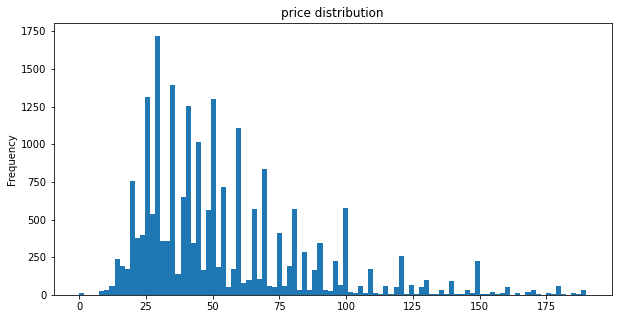

In [14]:
# set outliers thresholds
RANGE_THRESH = 3

# statistical Outliers
q1 = clean_listings_df['price'].quantile(0.25)
q3 = clean_listings_df['price'].quantile(0.75)
iqr = q3 - q1

# calculate boundaries of accepted prices
maximum = q3 + RANGE_THRESH * iqr
minimum = q1 - RANGE_THRESH * iqr

# keep only data in range
clean_listings_df = clean_listings_df[clean_listings_df['price'].between(minimum, maximum)]

# print the ratio of lost data
print("original listing dataframe has %d rows and %d columns" % listings_df.shape)
print("listing dataframe without outliers nor misising values has %d rows and %d columns" % clean_listings_df.shape)
print("We lost %.2f%% of data from original" % (100*(1-clean_listings_df.shape[0]/listings_df.shape[0])))

# plot distribution of prices
clean_listings_df['price'].plot(kind='hist', bins= 100, figsize=(10,5), title= "price distribution");

# display price descriptive metrics in table
pd.DataFrame(clean_listings_df['price'].describe()).T

2. As we work we numerical data only, we compute the correlation matrix. It will give us an idea on how features are correlated with each others (pairwise correlaton of columns). It shgows what features vary synchronously as we go through the listings. 

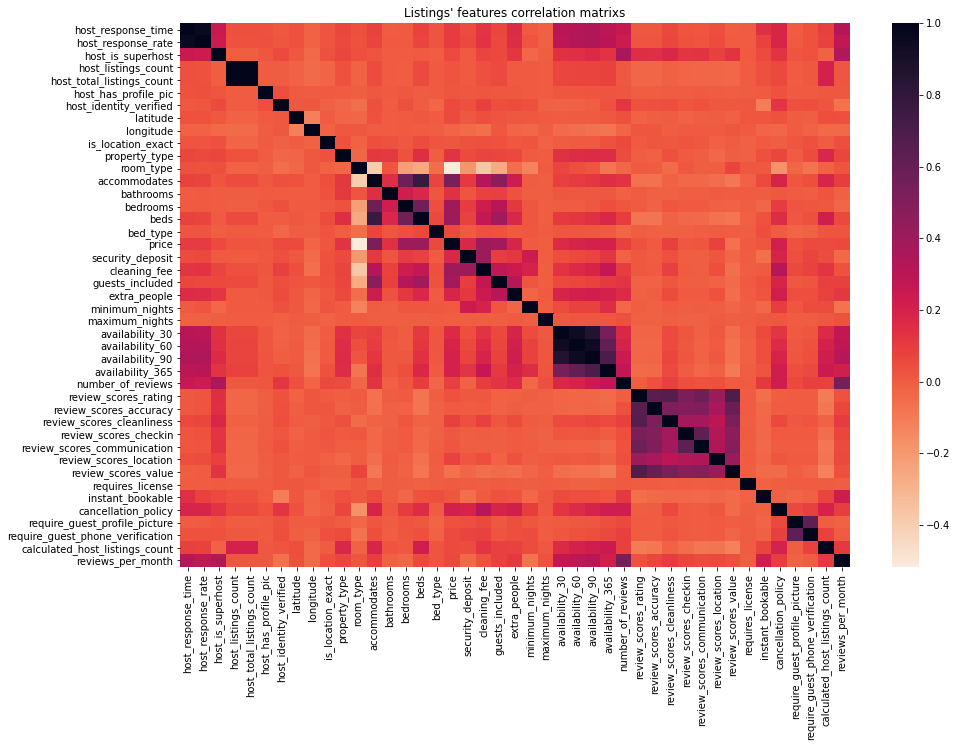

In [15]:
# calculate pairwise correlation
corr_df = clean_listings_df.corr()

# plot heat map with color code reflecting correltation between features
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(corr_df, ax=ax, cmap=sns.cm.rocket_r)

ax.set_title("Listings' features correlation matrixs");

**Observations:** here we have a good overview of correlated features. The darker, the more correlated. For instance, all review scores form one big dark rectangle (becasue side by side) thus they are highly correlated. Same thing for availability counts. These observations are expected but they confirm the correctness of this method. 

Our main focus is the price. From the above matrix, we summed up the 15 most correlated features to the price. The number of persons that can be accomodated, the number of beds and bedrooms are in the top 3. These are very practical concerns. Next, without surprise, the price may include the cleaning fees. Usually, an early reservation is less risky for the host and risk has a cost therefore cancelation policy is important, as well as security deposit. In the top 10 we find availability. In other words, how often the guest has left their property open for reservation.

In [16]:
# Focus on the 20 most correlated features to price only
price_corr_df = pd.DataFrame(corr_df['price'].drop('price').sort_values(ascending=False)).\
                        rename(columns={'price':'price correlation'}).head(15)

# present results in styled dataframe, numbers are rounded for better readability
price_corr_df.style.set_precision(3).bar(vmin=0)

,price correlation
accommodates,0.530
beds,0.410
bedrooms,0.403
cleaning_fee,0.401
guests_included,0.385
cancellation_policy,0.210
availability_90,0.204
availability_365,0.203
availability_60,0.192
extra_people,0.184


3. We dissociate input data from output data

In [17]:
# price will be the output of the model
y = clean_listings_df['price']

# All other features serve as inputs 
X = clean_listings_df.drop('price', axis=1)

# print new data representation
print("y has %d rows and 1 columns" % y.shape)
print("X has %d rows and %d columns" % X.shape)

y has 22008 rows and 1 columns
X has 22008 rows and 42 columns


4. We split the dataset between training and test data

In [18]:
from sklearn.model_selection import train_test_split

# split dataset between train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

5. We create an ensemble of 500 decision trees with a max depth of 7 to prevent from overfitting. Learning is optimized with a gradient boosting method. This model is simply known as the gradient boost.

>prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# create model with 500 decision trees with a max_depth of 7 to prevent from overfitting
model = GradientBoostingRegressor(max_depth=8, n_estimators=300, random_state=0, learning_rate=0.1)

# learn from training data
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=8, n_estimators=300, random_state=0)

### Test model

After training, we have to check the performance of our model on unseen data. It gives us an appreciation of the model. We are in measure to decide whether it is underfitting, overfitting, or good enough.

1. We evaluate the performance of the model with "R2 score" and "MAE": 
>**R2**: the coefficient of determination is the ratio between the variance explained by the model and the output variance from the mean. The closer to one, the better.<br>
>**MAE**: mean absolute error of model prediction against groundtruth. the lower the better.

In [20]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# predict outputs for training and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R2 score calculation
print("R2 score for training data \t %f" % r2_score(y_train_pred, y_train))
print("R2 score on test data \t\t %f" % r2_score(y_test_pred, y_test))
print()

# MAE calculation
print("MAE on training data \t\t %f" % mean_absolute_error(y_train_pred, y_train))
print("MAE on test data \t\t %f" % mean_absolute_error(y_test_pred, y_test))

R2 score for training data 	 0.923563
R2 score on test data 		 0.412274

MAE on training data 		 5.622226
MAE on test data 		 13.429252


**Observations:** The model performs very well on train data but less on the test data. However, this is the best we could achieve after fine tuning. The average error is 13.4$ on test data, half the standard deviation of the overall distribution. The model is certainly not the best but it could understand the underlying connection of features to the price.

### Feature relevance

We determine what features were the most informative to determine the price. We explore 2 different methods: open and closed. 

- **Open**: Decision trees are transparent models therefore we can open itl and see what features turned out to be the most relevant during learning.

In [21]:
# set table name for presentation of result
col_model_1 = 'mean feature relevance score from model'

# structure results in dataframe
feature_model_df = pd.DataFrame({col_model_1:model.feature_importances_}, index=X.columns).\
                            sort_values(by=col_model_1, ascending=False)

# present results in styled dataframe
feature_model_df.head(20).style.bar(subset=col_model_1, color='#C17F0B')

,mean feature relevance score from model
room_type,0.289000
accommodates,0.106442
latitude,0.067344
longitude,0.057322
cleaning_fee,0.054791
bedrooms,0.038364
extra_people,0.035306
guests_included,0.032288
minimum_nights,0.032014
availability_90,0.028752


2. **Closed**: we permute the rows of every features column randomly and check what is the impact on price prediction. If messing up with a feature leads to wrong prediction, the model is mostly relying on that feature. When predictions are unchanged, it means the feature is not so important. For each feature, permutations are reproduced many times so we end up with a mean and standard deviation. 

In [ ]:
from sklearn.inspection import permutation_importance

# parmute each columns 10 times and measure the impact on price prediction
result = permutation_importance(model, X_test, y_test, n_repeats=20,random_state=0)

#  set column name fro new data frame
col_perm_1 = 'mean feature relevance score from permutation'
col_perm_2 = 'std'

# set color map for std gradient 
cm = sns.light_palette('#C1B60B', as_cmap=True)

# structure results in dataframe
feature_perm_df = pd.DataFrame({col_perm_1:result.importances_mean, col_perm_2:result.importances_std}, index=X.columns).\
                                sort_values(by=col_perm_1, ascending=False)

# present results in styled dataframe
feature_perm_df.head(20).style.bar(subset=col_perm_1, color='#C1B60B').background_gradient(subset=col_perm_2, cmap=cm)

3. **Side by side**: open and closed

In [ ]:
# join both dataframes above and  
feature_combined_df = feature_perm_df.join(feature_model_df).drop('std', axis=1).dropna().\
                                                            sort_values(by=feature_model_df.columns[0], ascending=True)

# standardize both feature importance
feature_combined_df = feature_combined_df.apply(lambda col: col/col.std(), axis=0)

# bar plot illustrating feature relevance from both techniques
fig, ax = plt.subplots(2, 1,figsize=(5,10))

feature_model_df.sort_values(by=col_model_1).tail(15). \
                            plot(kind='barh', title='Feature relevance score form model', 
                            color='green', legend=False, ax=ax[0])

feature_perm_df[col_perm_1].sort_values().tail(15). \
                            plot(kind='barh', title='Feature relevance score form permutation', 
                            color='crimson', legend=False, ax=ax[1])

**Observations:** The model helps  us to refine the correlation analysis. It shows what we already know and more. The price varies with respect to very practical features such as the room type (private, apartment, shared,...), number of people that can be accomodated, the minimum number of nights, the cleaning fee, and the number of guests included. Again,availability has a little impact on the price. Unlike correlation, the model catched a noteworthy dependency on location. From both views, we notice that the reviews are not so important in pricing after all. 


# 3. How professional hosts stand out?

We want to find out who are airbnb professionals and what differentiates thenm from the rest of the hosts. For conducting this study, we assume professional hosts own more than  3 possessions. 

### Data clean up

1. We want to do statistics estimation therefore we need to clean up the data frame again. We have to reuse a part the work done in question 2.

In [ ]:
clean_listings_df = pd.read_csv(r'data\listings_summary.csv')

# binarize remaining columns
binary_columns = clean_listings_df.columns[clean_listings_df.nunique() == 2].tolist()
clean_listings_df[binary_columns] = (clean_listings_df[binary_columns] == 't').astype(float)

# columns to transform
col_to_transform = ['extra_people', 'price', 'security_deposit', 'security_deposit', 'cleaning_fee', 'host_response_rate']

# transform columns having string types instead of numrical types
clean_listings_df[col_to_transform] = clean_listings_df[col_to_transform]. \
                    apply(lambda col : col.str.replace(r',|\$|%','').astype('float'), axis=0)

### Professionals identification

1. We identify listings belonging to hosts having more than 3 possessions. Luckily, 
the number of listings per hosts are given already.

In [ ]:
# miniimum number of professions to be considered professionals
MIN_PROPERTY_THRESH = 3

# mark listings owned by professionals in new column
clean_listings_df['is_professional'] = False
clean_listings_df.loc[clean_listings_df['calculated_host_listings_count'] > MIN_PROPERTY_THRESH, 'is_professional'] = True

# print the percentage of listings owned by professionals
print( "The percentage of professional listings is %.2f%% " % (100*clean_listings_df['is_professional'].mean()))

### Comparision

1. We split the data between professionals and non professionals hosts. For both distinct groups, we compute the  mean of all numerical features available. Then, we calculate the standardized difference of  pairs for each features. Finally, we can visualize how both groups are balanced between features on the same scale. 

In [ ]:
# columns to be removed because not interesting or retruning nan aftger pivot
col_not_comparable = ['id', 'scrape_id', 'host_id','maximum_nights', 'calculated_host_listings_count',\
                        'calendar_last_scraped', 'last_scraped', 'host_listings_count', 'host_total_listings_count']

# pivot table by aggregating features mean values around professional and non professional host
compare_pro_df = pd.pivot_table(clean_listings_df.drop(col_not_comparable, axis=1), 
                              columns=['is_professional'], aggfunc='mean').dropna()

# calculate standard devisations of all features for normalization of diff
FeaturesStd = clean_listings_df.std().loc[compare_pro_df.index.tolist()]

# create a comapre table with normalized value difference in the middle
compare_pro_df = pd.DataFrame({'normal host mean': compare_pro_df[False],
                            'normalized diff': (compare_pro_df[True]-compare_pro_df[False]) / FeaturesStd,
                            'professional host mean': compare_pro_df[True]})

# sort table by "normalized diff" to know what features are predominant among professionals
compare_pro_df.sort_values(by='normalized diff', ascending = True, inplace=True)

# plot diagram with normalized difference  
fig, ax = plt.subplots(figsize=(5,10))

plt.hlines(y=compare_pro_df.index, xmin=0, xmax=compare_pro_df['normalized diff'], 
           color=['red' if x < 0 else 'green' for x in compare_pro_df['normalized diff']],
           alpha=0.4, linewidth=5)

ax.set_title('Standardized feature balance between non pro/left and pro/right')
ax.set_xlabel('standardized difference')

2. In the previous plot, Room type is not represented and yet, we know how important it is for the price. Let's see how both groups behave regarding that particular feature. 

In [ ]:
from matplotlib import cm

# group room type data between professional and non professionals
compare_pro_room_df = clean_listings_df.groupby('is_professional')['room_type'].value_counts(normalize=True).unstack().T

# rename index for display
compare_pro_room_df.rename(columns={True:'pro hosts', False:'non pro hosts'}, inplace=True)

# bar plot illustrating the disribution of room type between professionals and non professionals
compare_pro_room_df.plot(kind='bar', figsize=(5,5), rot=45,
                         title='Room type distribution  between professionals\n and non professionals hosts', \
                         ylabel='percentage', xlabel='room type',  cmap =cm.get_cmap('Dark2'))

**Observations:** We can see that Airbnb professionals are of course much more available for booking. The frequentation is certainly higher so they have more reviews. For a higher ratability, they have more beds and tend to allow extra people more often. Cleaning fees and security deposit are higher. It makes sense if you are running a business.<br> 
They have more facilities in general. However, the main takeaway from this analysis is that all review scores are lower for professionals although the average is quite high and very satisfying. <br> 

The last plot focus on room type. Professionals rent 18.6% more of entire apartments and 22.2% less private room than non-professionals. While activities of professionals is unbalanced, non-professionals split their activities almost equally between entire apartment and private room. Shared rooms are negligible in both groups.

# 4. Which language to communicate with guests?

We want to know which language speaks the majority of the guests. Such information may help someone who wants to step in the airbnb business and give out indications to guests. We have to witch dataframes and dig into the reviews. The reviews dataframe  gathers review commenta from the past 10 years.  

This part of the analysis makes use of NLP to read through all the reviews and detect the language.

In [ ]:
# set to True to read through all reviews again
RUN_NLP = False

### Text analysis

1. We invoke pretrained NLP mdel for language detection

In [ ]:
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language


if RUN_NLP:
    
    #set factory name 
    component_name = 'lang_detect_10'
    
    #create customized NLP factory for language detection
    @Language.factory(component_name, default_config={"last": True})
    def my_component(nlp, name, last: bool):
         return LanguageDetector()

    # create NLP pipeline
    nlp_model = spacy.load('en_core_web_sm')
    nlp_model.add_pipe(component_name, name='language_detector', last=True)

2. We pass all review comments to the model. It detects the language. It takes a lot of time so we save the result for not doing it repetedely.

In [ ]:
# function  for language detection
def detect_language(text):
    """ determine language in text and return language id"""
    
    try:
        # keep only the 10 words in text
        list_of_words = text.split()
        reduced_text = ' '.join(list_of_words[0 : min(10,len(list_of_words))])
        
        # return detected language in reduced text
        language = nlp_model(reduced_text)._.language['language']
    except:
        language = 'UNKNOWN'
    
    return language


if RUN_NLP:
    
    # apply lnaguage detection function to eacch review comments  
    reviews_df['language'] = reviews_df['comments'].head(1000).apply(detect_language)

    # save data frame in csv file
    reviews_df.to_csv(r'data\reviews_summary_with_language.csv')

### Visualization

1. We use a sorted bar plot to see most used languages in review comments

In [ ]:
from matplotlib import cm

#relaod data from storage
reviews_df = pd.read_csv(r'data\reviews_summary_with_language.csv')

# set color map
color = cm.inferno_r(np.linspace(.4, .8, 30))

# plot data sorted language counts
reviews_df['language'].value_counts(normalize=True).sort_values(ascending=True).tail(15).\
            plot(kind='bar', color=color, figsize=(5,5),  title = 'Percentage of languages used for reviews\' comments', \
                ylabel='percentage', xlabel='languages');

# save in file
plt.savefig(r'data\language_precentage.png', bbox_inches='tight')

# print total number of languages
print("total number of language %d:\t" % reviews_df['language'].nunique())

2. We fold the reviews comming from 8 full straight years (other years incomplete) onto one year. The we plot the distribution of reviews for the 5 top most lanquages. 

In [ ]:
#we select the data from the begining of 2010 to the begining of 2018
reviews_full_yas_df = reviews_df[pd.to_datetime(reviews_df['date']). \
                                  between(('2010-01-01 00:00:00'), ('2018-01-01 00:00:00'))]

# convert date into day of the year
reviews_full_yas_df['date'] = pd.to_datetime(reviews_full_yas_df['date']).dt.dayofyear 

# keep the most common languages
top_languages = (reviews_full_yas_df['language'].value_counts()[:4]).index.tolist()

#group data per date and count the number of reviews for eeach languages in columns
reviews_full_yas_df = reviews_full_yas_df.groupby('date')['language'].value_counts().unstack()[top_languages]

# plotlanguage count over the year
reviews_full_yas_df.plot(kind='area', figsize=(10, 4),stacked=False, xlabel='date', ylabel='count', \
                         title='Review language distribution over a year')

# save in file
#plt.savefig(r'data\language_distribution.png', bbox_inches='tight')

**Observations:**  The most common language is English with 66%, far beyond others. German is second with 18%. In third and fourth position, we find French with 4% and Spanish with 2%. Four languages are enough to cover 90% of guests.

A look at reviews over a year show that all languages stay within a certain range except English. English increase constantly and stabilize during summer. There is a surprising peak around the end of September and then, the number of reviews slowly go down until the end of the year. The New Year begins with a peak. The cycle is over and reviews ramp up again. Both German and English are abnormally high on the end of May. It seems to match with the period of the Pyronale (fireworks competition).

# Summary

 
The questions we have decided to answer brought us to different aspects of data science. We have begun this journey dealing with geospatial data, later with machine learning, basic statistics, and finally, we used some NLP. We may not have found what we were looking for, but we managed to get some interesting findings.<br><br>

**1. What neighborhoods do guests prefer?**<br>
We have grouped the number of listings by neighborhood. We projected the location review score and listings spread on a 2D map of Berlin. Guests appreciate the city center. This is also, where the hosts are concentrated. 
Guests also appreciate regions on the outskirts of the city such as Müggleheim in the South-West, Wannsee and Nikolassee in the Southeast, and Tegel in the North. 

**2. What justifies the price?**<br>
We have used correlation and machine learning to get insights from data. Either ways, we had to clean the data. The correlation revealed what features are in phase with the price. Machine learning confirmed most of them but it also revealed new ones. 
The room type, home capacity, bedroom type, and number of beds are all very important. ... Cleaning fees, extra people, position, and minimum night stay are noteworthy. Availability is recurrent but its role is less obvious. 

**3. How professional hosts stand out? <br>**
We splitted the data between 2 distinct groups: professionals, and non-professional. 
After comparison, it turned out professionals focus their activities on entire home apartments, and half of it go to private rooms where nonprofessionals are the most present. 
Professionals are more available and have more facilities. In general, they charge more but their service quality is less good than non-professionals. That being said, we can say they focus more on quantity.

**4. Which language to communicate with guests? <br>**
Thanks to a pre trained NLP model, we could read all reviews and detect the language. 4 languages are enough to cover 90% of guests' expectations. The distribution is exponential. In order of importance: English 66%, German 18%, French 4%, and Espanol 2%.
